# Setup

In [1]:
import os
import cv2
import json
import string
import random 
import gc
import csv
import pickle
import timm
import fractions
import numpy as np
from collections import Counter
from tqdm import tqdm
from matplotlib import pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.optim import Adam
from torch.optim import AdamW
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor
from torchvision.models.detection.image_list import ImageList
from transformers import DetrFeatureExtractor, DetrForObjectDetection
from torch.optim.lr_scheduler import ReduceLROnPlateau
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk.translate.bleu_score as bleu_score

data_dir = os.path.join('dataset')
# data_dir = os.path.join('dataset30K')
working_dir = os.path.join('working')
images_dir = os.path.join(data_dir,'Images')
captions_dir = os.path.join(data_dir,'captions.txt')

In [2]:
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU devices available.")
# *********************
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Device 0: NVIDIA GeForce GTX 1660 SUPER
Using device: cuda


In [3]:
# Load a pretrained Swin Transformer model
swin_model = timm.create_model('swin_large_patch4_window12_384', pretrained=True, num_classes=0)  # num_classes=0 removes the classification head
swin_model.to(device)

# Set model to evaluation mode
swin_model.eval()

# Freeze the Swin model parameters
for param in swin_model.parameters():
    param.requires_grad = False

In [ ]:
import timm

available_models = timm.list_models('*swin*')
print(available_models)


In [ ]:
# # Load a pretrained Swin Transformer model
# swin_model = timm.create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=0)  # num_classes=0 removes the classification head
# swin_model.to(device)
# swin_model.train()  # Set to training mode

# # Optionally, you might still want to freeze some layers if you don't want to train the entire model
# # Example: Freezing earlier layers but training later layers
# for name, param in swin_model.named_parameters():
#     if 'stage4' in name:  # Just an example, adjust according to your needs
#         param.requires_grad = True
#     else:
#         param.requires_grad = False


In [7]:
# Load pretrained DETR model and feature extractor
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")
detr_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").to(device)

# Set model to evaluation mode
detr_model.eval()

# Freeze the Swin model parameters
for param in detr_model.parameters():
    param.requires_grad = False

C:\Users\Mohamed\anaconda3\Lib\site-packages\transformers\models\detr\feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForO

# Preprocess & encode captions

In [9]:
# for flickr8k
def load_captions(filepath):
    captions = {}
    with open(filepath, 'r', encoding='utf-8') as file:
        reader = csv.reader(file) 
        for row in reader:
            if len(row) != 2:
                print(f"Skipping malformed line: {row[:50]}...")  
                continue
            image_id, caption = row
            image_id = image_id.split('.')[0]  
            if image_id not in captions:
                captions[image_id] = []
            captions[image_id].append(caption)
    
    return captions
captions = load_captions(captions_dir)

In [11]:
def clean_and_tokenize(caption):
    tokens = caption.lower().translate(str.maketrans('', '', string.punctuation)).split()
    return tokens
    
# Collect all captions
all_captions = []
for cap_list in captions.values():
    all_captions.extend(cap_list)
    
# Count word frequencies
word_counts = Counter()
for caption in all_captions:
    word_counts.update(clean_and_tokenize(caption))

# Create a vocabulary with words that exist in both Word2Vec and your dataset
vocab = [word for word, count in word_counts.items() if count >= 2]

# Map words to indices for the special tokens
word_to_ix = {word: ix for ix, word in enumerate(vocab, start=4)}  # start=4 to leave 0 for <PAD>, 1 for <START>, 2 for <END>, 3 for <UNK>
word_to_ix['<PAD>'] = 0
word_to_ix['<START>'] = 1
word_to_ix['<END>'] = 2
word_to_ix['<UNK>'] = 3

# Reverse lookup for decoding
ix_to_word = {ix: word for word, ix in word_to_ix.items()}

# Update vocab size
vocab_size = len(word_to_ix)
vocab_size

5224

In [13]:
vocab_file_path = 'vocab.json'
with open('vocab.json', 'w') as vocab_file:
    json.dump(word_to_ix, vocab_file)

In [15]:
def encode_caption(caption, word_to_ix, max_length):
    tokens = clean_and_tokenize(caption)
    tokens = ['<START>'] + tokens + ['<END>']
    caption_ids = [word_to_ix.get(token, word_to_ix['<UNK>']) for token in tokens]
    if len(caption_ids) < max_length:
        caption_ids += [word_to_ix['<PAD>']] * (max_length - len(caption_ids))
    else:
        caption_ids = caption_ids[:max_length]
    return np.array(caption_ids)

max_length = max(len(clean_and_tokenize(caption)) + 2 for caption in all_captions)  # +2 for <START> and <END>
encoded_captions = {img_id: [encode_caption(caption, word_to_ix, max_length) for caption in cap_list]
                    for img_id, cap_list in captions.items()}


# Features extraction

In [17]:
def extract_swin_features(swin_model, image_tensor):
    # Extract features
    with torch.no_grad():
        features = swin_model(image_tensor)  # Image tensor already preprocessed
    return features.view(features.size(0), -1)  # Flatten into [batch_size, feature_dim]

def extract_detr_features(detr_model, image_tensor, target_size=1536):
    with torch.no_grad():
        # Get outputs from the DETR model
        outputs = detr_model(image_tensor)

    # Extract object queries (decoder hidden states)
    object_queries = outputs.last_hidden_state  # Output of the last decoder layer

    # Flatten the object queries into a 2D tensor [batch_size, num_queries * hidden_dim]
    flattened_object_queries = object_queries.view(object_queries.size(0), -1)

    # If needed, reduce dimensionality via mean pooling to match target size (1536)
    if flattened_object_queries.size(1) > target_size:
        pooled_object_queries = torch.nn.functional.adaptive_avg_pool1d(
            flattened_object_queries.unsqueeze(0), target_size).squeeze(0)
    else:
        pooled_object_queries = flattened_object_queries

    return pooled_object_queries.cpu()

In [19]:
# List of image IDs (filenames without extension)
image_ids = [img_name.split('.')[0] for img_name in os.listdir(images_dir) if img_name.endswith('.jpg')]

# Set up transforms for training and validation/test
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((384, 384)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Define the transform used during feature extraction (should be fixed)
feature_extraction_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [21]:
# Load features from a .pkl file or extract them if not present
if data_dir == 'dataset':
    features_file = 'featuresMixed.pkl'
    print('using flickr8K dataset')
elif data_dir == 'dataset30K':
    features_file = 'featuresMixed30K.pkl'
    print('using flickr30K dataset')
else:
    raise ValueError(f"Unrecognized dataset")
    
features_dict = {}
if os.path.exists(features_file):
    with open(features_file, 'rb') as f:
        features_dict = pickle.load(f)
else:
    # Extract features for each image and save them
    for image_id in tqdm(image_ids):
        image_path = os.path.join(images_dir, image_id + '.jpg')
        if os.path.exists(image_path):
            swin_features = extract_swin_features(swin_model,image_path, feature_extraction_transform)
            detr_features = extract_detr_features(detr_model,image_path, feature_extraction_transform, target_size=1536)
            features_dict[image_id] = (swin_features, detr_features)

    with open(features_file, 'wb') as f:
        pickle.dump(features_dict, f)

using flickr8K dataset


# Model building

In [24]:
class Flickr8kDataset(Dataset):
    def __init__(self, image_dir, captions, encoded_captions, image_ids, transform, swin_model, detr_model):
        """
        Args:
            image_dir (str): Directory containing images.
            captions (dict): Dictionary mapping image IDs to captions.
            encoded_captions (dict): Dictionary mapping image IDs to encoded captions.
            image_ids (list): List of image IDs.
            transform (callable, optional): Transformations to apply to images before feeding into the model.
            swin_model (torch.nn.Module): Swin Transformer model for feature extraction.
            detr_model (torch.nn.Module): DETR model for feature extraction.
            device (torch.device): Device to use for computation (GPU or CPU).
        """
        self.image_dir = image_dir
        self.captions = captions
        self.encoded_captions = encoded_captions
        self.image_ids = image_ids
        self.transform = transform
        self.swin_model = swin_model
        self.detr_model = detr_model
        self.device = device

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id + '.jpg')

        # Load and transform image
        image = Image.open(image_path).convert("RGB")
        image_tensor = self.transform(image).unsqueeze(0).to(device)

        # Extract features using Swin Transformer and DETR
        swin_features = extract_swin_features(self.swin_model, image_tensor).to(device)
        detr_features = extract_detr_features(self.detr_model, image_tensor).to(device)
      
        # Combine features
        features = torch.cat([swin_features, detr_features], dim=1)
        # print(f"Combined Features Shape: {features.shape}")
        
        # Retrieve the encoded captions for this image
        captions_for_image = np.array(self.encoded_captions[image_id])
        caption = torch.tensor(captions_for_image, dtype=torch.long)

        return features, caption

In [25]:
def custom_collate_fn(batch):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Filter out None values
    batch = list(filter(lambda x: x is not None, batch))
    if len(batch) == 0:
        return torch.tensor([]).to(device), torch.tensor([]).to(device)  # Return empty tensors if the batch is empty

    
    features, captions = zip(*batch)
    
    # Determine the maximum feature size
    max_feature_size = max(feature.size(1) for feature in features)
    
    # Pad feature tensors to the maximum size
    features = torch.stack([
        torch.cat((feature.to(device), torch.zeros((feature.size(0), max_feature_size - feature.size(1)), device=device)), dim=1)
        for feature in features
    ])
    
    captions = torch.stack(captions).to(device)
    return features, captions
    
print(type(captions))  # This should print <class 'dict'>

<class 'dict'>


In [26]:
# Shuffle and split data
image_ids = list(captions.keys())
random.seed(42)
random.shuffle(image_ids)

# Calculate indices for splits
total_images = len(image_ids)
train_end = int(0.7 * total_images)
val_end = int(0.9 * total_images)

train_ids = image_ids[:train_end]
val_ids = image_ids[train_end:val_end]
test_ids = image_ids[val_end:]

In [27]:
train_dataset = Flickr8kDataset(images_dir, captions, encoded_captions, train_ids, train_transform, swin_model, detr_model)
val_dataset = Flickr8kDataset(images_dir, captions, encoded_captions, val_ids, test_transform, swin_model, detr_model)
test_dataset = Flickr8kDataset(images_dir, captions, encoded_captions, test_ids, test_transform, swin_model, detr_model)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn)

In [28]:
feature_size = 3072

In [34]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, feature_size, hidden_size, vocab_size, embed_size, dropout):
        super(ImageCaptioningModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=2, batch_first=True)
        self.lstm_dropout = nn.Dropout(dropout)  # Dropout after LSTM
        self.fc1 = nn.Linear(hidden_size, hidden_size)  # First FC layer
        self.fc1_dropout = nn.Dropout(dropout)  # Additional dropout after FC1
        self.fc2 = nn.Linear(hidden_size, vocab_size)   # Second FC layer
        self.feature_fc = nn.Linear(feature_size, embed_size)  # Adapting Swin output to LSTM
    
    def forward(self, features, captions):
        features = features.to(device)
        captions = captions.to(device)
        
        # Project features to embedding size
        batch_size = features.size(0)
        features = self.feature_fc(features)  # Should be of shape [batch_size, embed_size]
        features = features.unsqueeze(1)# Add a sequence dimension: [batch_size, 1, embed_size]

        # Prepare LSTM inputs
        embeddings = self.embedding(captions)
        embeddings = self.dropout(embeddings)  # Dropout after embedding layer
        inputs = torch.cat((features, embeddings[:, :-1, :]), dim=1)  # Concatenate features with captions
        
        # Pass through LSTM
        hiddens, _ = self.lstm(inputs)
        hiddens = self.lstm_dropout(hiddens)  # Dropout after LSTM hidden states
        hiddens = F.relu(self.fc1(hiddens))
        hiddens = self.fc1_dropout(hiddens)  # Additional dropout after FC1
        outputs = self.fc2(hiddens)
        return outputs




hidden_size = 1024
embed_size = 512
dropout = 0.5
captioning_model = ImageCaptioningModel(feature_size, hidden_size, vocab_size, embed_size, dropout)
captioning_model = captioning_model.to(device)

In [35]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.01):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Training & Validation

In [37]:
# Training loop
criterion = nn.CrossEntropyLoss(ignore_index=word_to_ix['<PAD>'])
optimizer = Adam(captioning_model.parameters(), lr=0.004, weight_decay=0.0001)
# Add a StepLR scheduler - decays the learning rate by gamma every 'step_size' epochs
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=0.01, min_lr=1e-5)
num_epochs = 100
early_stopping = EarlyStopping(patience=4, delta=0.01)  # Adjust patience and delta as needed
train_loss_values = []
val_loss_values = []

# Create a tqdm instance to show global progress for training and validation
total_steps = num_epochs * len(train_loader) + num_epochs * len(val_loader)
with tqdm(total=total_steps, desc='Training Progress') as pbar:
    for epoch in range(num_epochs):
        captioning_model.train()
        epoch_train_loss = 0
        for i, (features, captions) in enumerate(train_loader):
            if features.shape[0] == 0:  # Skip if batch is empty
                continue
                
            # Move inputs and targets to the selected device (GPU or CPU)
            features = features.to(device)
            captions = captions.to(device)

            optimizer.zero_grad()

            # Get the size of the captions
            batch_size, num_captions, seq_len = captions.size()

            # Squeeze out the extra dimensions in `features` to make it [batch_size, feature_size]
            features = features.squeeze(1)  # Removing the unnecessary singleton dimensions

            # Now expand the features to repeat them across the captions dimension
            features = features.unsqueeze(1).expand(-1, num_captions, -1)  # [batch_size, num_captions, feature_size]

            # Flatten features and captions for input to the model
            features = features.contiguous().view(batch_size * num_captions, -1)
            captions = captions.view(batch_size * num_captions, seq_len)

            # Forward pass
            outputs = captioning_model(features, captions)
            loss = criterion(outputs[:, :captions.size(1), :].view(-1, vocab_size), captions.view(-1))

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

            pbar.set_postfix({'Step': i, 'Loss': loss.item()})
            pbar.update(1)
        
        epoch_train_loss /= len(train_loader)
        train_loss_values.append(epoch_train_loss)
       
        # Validation loop
        captioning_model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for features, captions in val_loader:
                if features.shape[0] == 0:  # Skip empty batches
                    continue
                # Move inputs and targets to the selected device (GPU or CPU)
                features = features.to(device)
                captions = captions.to(device)
                
                # Get the size of the captions
                batch_size, num_captions, seq_len = captions.size()

                # Squeeze and expand features just like in the training loop
                features = features.squeeze(1)  # Remove unnecessary singleton dimensions
                features = features.unsqueeze(1).expand(-1, num_captions, -1)  # Expand to match num_captions
                features = features.contiguous().view(batch_size * num_captions, -1)

                captions = captions.view(batch_size * num_captions, seq_len)

                # Forward pass
                outputs = captioning_model(features, captions)
                loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
                epoch_val_loss += loss.item()

        epoch_val_loss /= len(val_loader)
        val_loss_values.append(epoch_val_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}],  ' f'Training Loss: {epoch_train_loss:.3f},  ' f'Validation Loss: {epoch_val_loss:.3f}')
        
        # Update the learning rate scheduler based on validation loss
        scheduler.step(epoch_val_loss)

        # Early stopping
        early_stopping(epoch_val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

Training Progress:   1%|          | 177/22800 [13:58<30:27:35,  4.85s/it, Step=176, Loss=3.68]

Epoch [1/100],  Training Loss: 4.287,  Validation Loss: 3.489


Training Progress:   2%|▏         | 354/22800 [31:39<29:00:51,  4.65s/it, Step=176, Loss=3.35]

Epoch [2/100],  Training Loss: 3.475,  Validation Loss: 3.198


Training Progress:   2%|▏         | 531/22800 [49:13<29:05:43,  4.70s/it, Step=176, Loss=3.22]

Epoch [3/100],  Training Loss: 3.271,  Validation Loss: 3.069


Training Progress:   3%|▎         | 708/22800 [1:06:41<28:40:19,  4.67s/it, Step=176, Loss=3.21]

Epoch [4/100],  Training Loss: 3.152,  Validation Loss: 3.007


Training Progress:   4%|▍         | 885/22800 [1:24:12<28:16:15,  4.64s/it, Step=176, Loss=3.11]

Epoch [5/100],  Training Loss: 3.082,  Validation Loss: 2.949


Training Progress:   5%|▍         | 1062/22800 [1:41:45<27:58:42,  4.63s/it, Step=176, Loss=3.03]

Epoch [6/100],  Training Loss: 3.033,  Validation Loss: 2.908


Training Progress:   5%|▌         | 1239/22800 [1:59:16<27:44:32,  4.63s/it, Step=176, Loss=3.03]

Epoch [7/100],  Training Loss: 3.002,  Validation Loss: 2.883


Training Progress:   6%|▌         | 1416/22800 [2:16:45<27:40:26,  4.66s/it, Step=176, Loss=2.85]

Epoch [8/100],  Training Loss: 2.978,  Validation Loss: 2.864


Training Progress:   7%|▋         | 1593/22800 [2:34:11<27:37:18,  4.69s/it, Step=176, Loss=3]   

Epoch [9/100],  Training Loss: 2.954,  Validation Loss: 2.850


Training Progress:   8%|▊         | 1770/22800 [2:51:30<26:43:47,  4.58s/it, Step=176, Loss=2.85]

Epoch [10/100],  Training Loss: 2.942,  Validation Loss: 2.843


Training Progress:   9%|▊         | 1947/22800 [3:08:39<26:30:58,  4.58s/it, Step=176, Loss=2.83]

Epoch [11/100],  Training Loss: 2.929,  Validation Loss: 2.833


Training Progress:   9%|▉         | 2124/22800 [3:25:50<26:18:13,  4.58s/it, Step=176, Loss=2.99]

Epoch [12/100],  Training Loss: 2.921,  Validation Loss: 2.850


Training Progress:  10%|█         | 2301/22800 [3:43:00<26:07:06,  4.59s/it, Step=176, Loss=2.87]

Epoch [13/100],  Training Loss: 2.915,  Validation Loss: 2.828


Training Progress:  11%|█         | 2478/22800 [4:00:11<27:00:02,  4.78s/it, Step=176, Loss=3.17]

Epoch [14/100],  Training Loss: 2.908,  Validation Loss: 2.820


Training Progress:  12%|█▏        | 2655/22800 [4:17:30<25:38:16,  4.58s/it, Step=176, Loss=2.91]

Epoch [15/100],  Training Loss: 2.897,  Validation Loss: 2.826


Training Progress:  12%|█▏        | 2832/22800 [4:34:42<25:31:05,  4.60s/it, Step=176, Loss=2.82]

Epoch [16/100],  Training Loss: 2.774,  Validation Loss: 2.709


Training Progress:  13%|█▎        | 3009/22800 [4:51:54<25:15:12,  4.59s/it, Step=176, Loss=2.8] 

Epoch [17/100],  Training Loss: 2.736,  Validation Loss: 2.700


Training Progress:  14%|█▍        | 3186/22800 [5:09:07<25:03:24,  4.60s/it, Step=176, Loss=2.82]

Epoch [18/100],  Training Loss: 2.726,  Validation Loss: 2.687


Training Progress:  15%|█▍        | 3363/22800 [5:26:19<24:48:17,  4.59s/it, Step=176, Loss=2.73]

Epoch [19/100],  Training Loss: 2.709,  Validation Loss: 2.672


Training Progress:  16%|█▌        | 3540/22800 [5:43:32<24:35:47,  4.60s/it, Step=176, Loss=2.67]

Epoch [20/100],  Training Loss: 2.697,  Validation Loss: 2.670


Training Progress:  16%|█▋        | 3717/22800 [6:00:43<24:19:53,  4.59s/it, Step=176, Loss=2.86]

Epoch [21/100],  Training Loss: 2.684,  Validation Loss: 2.666


Training Progress:  17%|█▋        | 3894/22800 [6:17:55<24:06:12,  4.59s/it, Step=176, Loss=2.53]

Epoch [22/100],  Training Loss: 2.673,  Validation Loss: 2.641


Training Progress:  18%|█▊        | 4071/22800 [6:35:06<23:52:02,  4.59s/it, Step=176, Loss=2.77]

Epoch [23/100],  Training Loss: 2.665,  Validation Loss: 2.645


Training Progress:  19%|█▊        | 4248/22800 [6:52:18<23:39:13,  4.59s/it, Step=176, Loss=2.75]

Epoch [24/100],  Training Loss: 2.653,  Validation Loss: 2.639


Training Progress:  19%|█▉        | 4425/22800 [7:09:30<23:30:01,  4.60s/it, Step=176, Loss=2.67]

Epoch [25/100],  Training Loss: 2.645,  Validation Loss: 2.624


Training Progress:  20%|██        | 4602/22800 [7:26:42<23:12:09,  4.59s/it, Step=176, Loss=2.63]

Epoch [26/100],  Training Loss: 2.639,  Validation Loss: 2.630


Training Progress:  21%|██        | 4779/22800 [7:43:53<22:57:29,  4.59s/it, Step=176, Loss=2.45]

Epoch [27/100],  Training Loss: 2.528,  Validation Loss: 2.557


Training Progress:  22%|██▏       | 4956/22800 [8:01:04<22:42:40,  4.58s/it, Step=176, Loss=2.32]

Epoch [28/100],  Training Loss: 2.493,  Validation Loss: 2.551


Training Progress:  23%|██▎       | 5133/22800 [8:18:15<22:31:02,  4.59s/it, Step=176, Loss=2.63]

Epoch [29/100],  Training Loss: 2.479,  Validation Loss: 2.540


Training Progress:  23%|██▎       | 5310/22800 [8:35:26<22:15:45,  4.58s/it, Step=176, Loss=2.72]

Epoch [30/100],  Training Loss: 2.469,  Validation Loss: 2.534


Training Progress:  24%|██▍       | 5487/22800 [8:52:37<22:03:25,  4.59s/it, Step=176, Loss=2.65]

Epoch [31/100],  Training Loss: 2.453,  Validation Loss: 2.527


Training Progress:  25%|██▍       | 5664/22800 [9:09:48<21:54:29,  4.60s/it, Step=176, Loss=2.67]

Epoch [32/100],  Training Loss: 2.442,  Validation Loss: 2.529


Training Progress:  26%|██▌       | 5841/22800 [9:27:06<21:48:07,  4.63s/it, Step=176, Loss=2.42]

Epoch [33/100],  Training Loss: 2.431,  Validation Loss: 2.526


Training Progress:  26%|██▋       | 6018/22800 [9:44:28<21:54:14,  4.70s/it, Step=176, Loss=2.46]

Epoch [34/100],  Training Loss: 2.420,  Validation Loss: 2.515


Training Progress:  27%|██▋       | 6195/22800 [10:01:57<21:35:39,  4.68s/it, Step=176, Loss=2.56]

Epoch [35/100],  Training Loss: 2.411,  Validation Loss: 2.527


Training Progress:  28%|██▊       | 6372/22800 [10:19:24<21:10:56,  4.64s/it, Step=176, Loss=2.45]

Epoch [36/100],  Training Loss: 2.330,  Validation Loss: 2.485


Training Progress:  29%|██▊       | 6549/22800 [10:36:53<20:56:52,  4.64s/it, Step=176, Loss=2.38]

Epoch [37/100],  Training Loss: 2.301,  Validation Loss: 2.480


Training Progress:  30%|██▉       | 6726/22800 [10:54:03<20:25:49,  4.58s/it, Step=176, Loss=2.39]

Epoch [38/100],  Training Loss: 2.288,  Validation Loss: 2.480


Training Progress:  30%|███       | 6903/22800 [11:11:22<20:28:09,  4.64s/it, Step=176, Loss=2.32]

Epoch [39/100],  Training Loss: 2.277,  Validation Loss: 2.481


Training Progress:  31%|███       | 7080/22800 [11:28:32<20:00:54,  4.58s/it, Step=176, Loss=2.21]

Epoch [40/100],  Training Loss: 2.264,  Validation Loss: 2.468


Training Progress:  32%|███▏      | 7257/22800 [11:45:52<19:45:27,  4.58s/it, Step=176, Loss=2.18]

Epoch [41/100],  Training Loss: 2.204,  Validation Loss: 2.456


Training Progress:  33%|███▎      | 7434/22800 [12:03:18<19:52:48,  4.66s/it, Step=176, Loss=2.26]

Epoch [42/100],  Training Loss: 2.190,  Validation Loss: 2.456


Training Progress:  33%|███▎      | 7611/22800 [12:20:34<19:19:28,  4.58s/it, Step=176, Loss=2.26]

Epoch [43/100],  Training Loss: 2.175,  Validation Loss: 2.456


Training Progress:  34%|███▍      | 7788/22800 [12:37:51<19:21:18,  4.64s/it, Step=176, Loss=2.15]

Epoch [44/100],  Training Loss: 2.168,  Validation Loss: 2.453


Training Progress:  35%|███▍      | 7965/22800 [12:58:33<24:10:05,  5.86s/it, Step=176, Loss=2.26]

Epoch [45/100],  Training Loss: 2.158,  Validation Loss: 2.455
Early stopping


In [40]:
model_save_path = 'captioning_model.pth'

# Save the model's state dictionary
torch.save(captioning_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to captioning_model.pth


In [41]:
# Define the path where the model is saved
model_save_path = 'captioning_model.pth'

# Load the state dictionary into the model
captioning_model.load_state_dict(torch.load(model_save_path))
# Set the model to evaluation mode
captioning_model.eval()

print(f"Model loaded from {model_save_path}")

Model loaded from captioning_model.pth


C:\Users\Mohamed\AppData\Local\Temp\ipykernel_16188\3224590603.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  captioning_model.load_state_dict(torch.load(model_save_pat

In [42]:
# Save loss values to a file
with open('train_loss_values.json', 'w') as f:
    json.dump(train_loss_values, f)
# Save loss values to a file
with open('val_loss_values.json', 'w') as f:
    json.dump(val_loss_values, f)

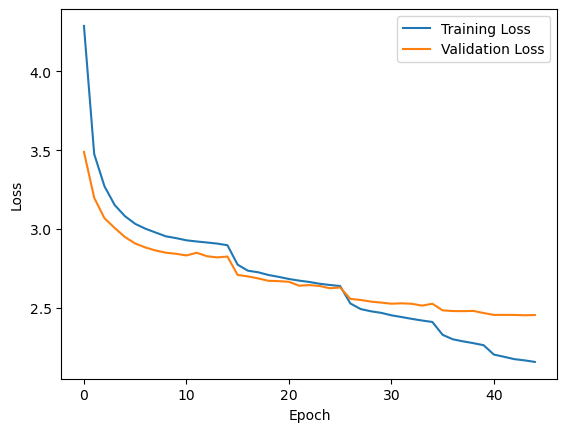

In [43]:
def load_json(filename):
    try:
        with open(filename, 'r') as f:
            data = json.load(f)
        if not data:
            print(f"Warning: {filename} is empty.")
        return data
    except FileNotFoundError:
        print(f"Error: {filename} not found.")
        return None
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {filename}.")
        return None

# Load the loss values
train_loss_values = load_json('train_loss_values.json')
val_loss_values = load_json('val_loss_values.json')

# show thier values
train_loss_values ,val_loss_values

# Simplified plot without specifying figsize
plt.plot(train_loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [44]:
# Testing phase
captioning_model.eval()
test_loss = 0
with torch.no_grad():
    for features, captions in test_loader:
        if features.shape[0] == 0:  # Skip empty batches
            continue
        # Move inputs and targets to the selected device (GPU or CPU)
        features = features.to(device)
        captions = captions.to(device)
                
        # Get the size of the captions
        batch_size, num_captions, seq_len = captions.size()

        # Squeeze and expand features like in training and validation loops
        features = features.squeeze(1) # Remove unnecessary singleton dimensions
        features = features.unsqueeze(1).expand(-1, num_captions, -1)  # Expand to match num_captions
        features = features.contiguous().view(batch_size * num_captions, -1)

        captions = captions.view(batch_size * num_captions, seq_len)

        # Forward pass
        outputs = captioning_model(features, captions)
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        test_loss += loss.item()

# Compute average test loss
test_loss /= len(test_loader)
print(f'Test Loss: {test_loss}')


Test Loss: 2.489726470066951


# Inference

In [46]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = feature_extraction_transform(image).unsqueeze(0)  # Add batch dimension
    return image
    
def extract_swin_image_features(model, image_path):
    image_tensor = preprocess_image(image_path).to(device)
    with torch.no_grad():
        features = swin_model(image_tensor)
    return features.view(features.size(0), -1)

def extract_detr_image_features(model, image_path, target_size=1536):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((384, 384))

    inputs = feature_extractor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs['pixel_values']
    
    with torch.no_grad():
        outputs = model(pixel_values)
    object_queries = outputs.last_hidden_state 
    
    flattened_object_queries = object_queries.view(object_queries.size(0), -1) 

    # If needed, reduce dimensionality via mean pooling to match target size (1536)
    if flattened_object_queries.size(1) > target_size:
        pooled_object_queries = torch.nn.functional.adaptive_avg_pool1d(
            flattened_object_queries.unsqueeze(0), target_size).squeeze(0)
    else:
        pooled_object_queries = flattened_object_queries

    return pooled_object_queries.cpu()

In [47]:
def remove_repetitive_words(caption):
    words = caption.split()
    filtered_words = [words[0]]  # Initialize with the first word
    
    for i in range(1, len(words)):
        if words[i] != words[i - 1]:
            filtered_words.append(words[i])
    
    return ' '.join(filtered_words)

def generate_caption(captioning_model, swin_model, detr_model, image_path, word_to_ix, ix_to_word, max_length, feature_size, beam_size=5):
    """
    Generate a caption for an image using the trained captioning model and Swin Transformer for feature extraction.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Preprocess the image to extract features
    image = Image.open(image_path).convert("RGB")
    image = feature_extraction_transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    with torch.no_grad():
         # Extract features from Swin Transformer
        swin_features = extract_swin_image_features(swin_model, image_path).to(device)  # Swin features

        # Extract features from DETR
        detr_features = extract_detr_image_features(detr_model, image_path, target_size=1536).to(device)  # DETR features

        # Combine features from both models
        features = torch.cat([swin_features, detr_features], dim=1)  # Concatenate along the feature dimension

    # Initialize beam search
    beam = [([word_to_ix['<START>']], 0)]  # (sequence, score)
    for _ in range(max_length):
        new_beam = []
        for seq, score in beam:
            caption_tensor = torch.tensor(seq, dtype=torch.long).unsqueeze(0).to(device)  # Move to device
            with torch.no_grad():
                outputs = captioning_model(features, caption_tensor)
            
            # Get top beam_size predictions
            top_k_scores, top_k_ids = torch.topk(outputs[0, -1], beam_size)
            
            for i in range(beam_size):
                new_seq = seq + [top_k_ids[i].item()]
                new_score = score + top_k_scores[i].item()
                new_beam.append((new_seq, new_score))

        # Keep only the top beam_size sequences
        beam = sorted(new_beam, key=lambda x: x[1], reverse=True)[:beam_size]
        
        # Check for end token
        if any(seq[-1] == word_to_ix['<END>'] for seq, _ in beam):
            break

    # Choose the best sequence
    best_seq = max(beam, key=lambda x: x[1])[0]

    # Skip <START> and <END> tokens
    caption = ' '.join([ix_to_word[ix] for ix in best_seq if ix not in [word_to_ix['<START>'], word_to_ix['<END>']]])

    # Remove repetitive words from the caption
    caption = remove_repetitive_words(caption)
    
    return caption

In [48]:
# Function to randomly select 5 images from the directory
def get_random_images(image_dir, num_images=5):
    all_images = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(('jpg', 'jpeg', 'png'))]
    return random.sample(all_images, num_images)

# Function to generate caption and plot the image
def generate_and_plot_image(image_path, captioning_model, swin_model, detr_model, word_to_ix, ix_to_word, max_length=30, feature_size=3072):
    try:
        # Synchronize CUDA (if available)
        torch.cuda.synchronize()

        # Load and process the image
        imagez = Image.open(image_path).convert('RGB')
        
        # Generate caption using preloaded models
        caption = generate_caption(captioning_model, swin_model, detr_model, image_path, word_to_ix, ix_to_word, max_length, feature_size, beam_size=3)
        
        # Convert image to numpy array
        image_array = np.array(imagez)
        
        # Create a new figure
        fig, ax = plt.subplots()
        
        # Plot the image and add the caption
        ax.imshow(image_array)
        ax.axis('off')  # Hide axes
        ax.set_title(caption)
        
        # Save the image with caption
        save_path = os.path.splitext(image_path)[0] + '_with_caption.png'
        fig.savefig(save_path, bbox_inches='tight', pad_inches=0)  # Save the plot as a PNG file
        
        # Display the image and the caption
        plt.show()  # Ensure the image is displayed with the caption
        
        # Clear the figure
        plt.close(fig)  # Close the figure after displaying

        # Free resources by clearing the GPU cache and forcing garbage collection
        torch.cuda.empty_cache()  # Clear the GPU cache
        gc.collect()  # Force garbage collection to free RAM

    except Exception as e:
        print(f"Error during caption generation for {image_path}: {e}")

Generating caption for: dataset\Images\3104182973_5bb1c31275.jpg


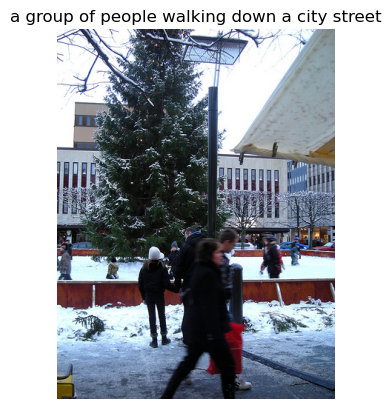

Generating caption for: dataset\Images\2285570521_05015cbf4b.jpg


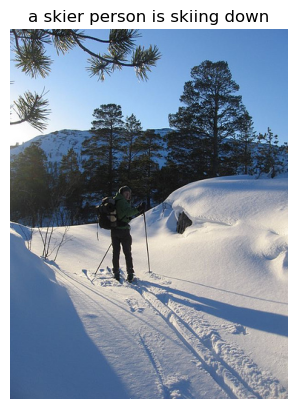

Generating caption for: dataset\Images\2244613488_4d1f9edb33.jpg


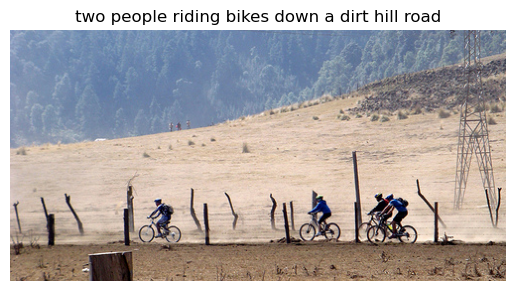

Generating caption for: dataset\Images\3399284917_721aefe2a7.jpg


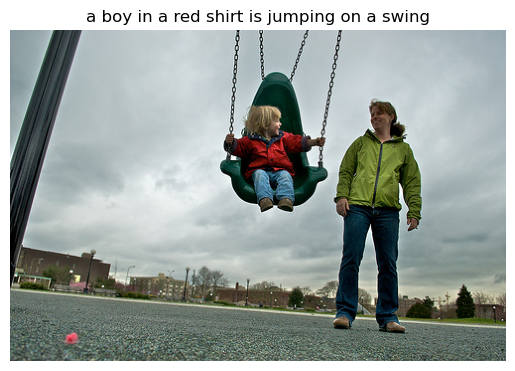

Generating caption for: dataset\Images\489773343_a8aecf7db3.jpg


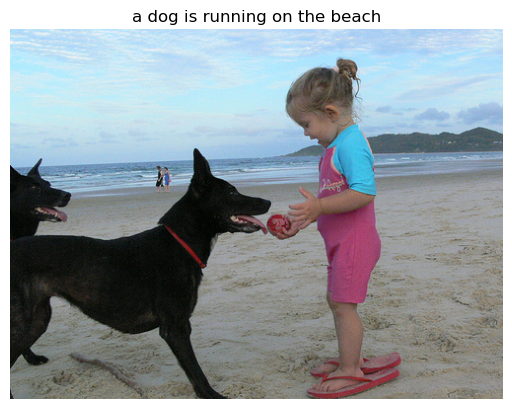

In [49]:
# Main function to generate captions for 5 random images
def caption_random_images(images_dir, captioning_model, swin_model, detr_model, word_to_ix, ix_to_word):
    random_images = get_random_images(images_dir, num_images=5)
    
    for image_path in random_images:
        print(f"Generating caption for: {image_path}")
        generate_and_plot_image(image_path, captioning_model, swin_model, detr_model, word_to_ix, ix_to_word)

# Call the function to generate captions for 5 random images
caption_random_images(images_dir, captioning_model, swin_model, detr_model, word_to_ix, ix_to_word)

# Metrics scores

In [51]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction


In [52]:
# Custom fraction class to avoid the unexpected keyword argument '_normalize' issue
class CustomFraction(fractions.Fraction):
    def __new__(cls, numerator=0, denominator=None, _normalize=True):
        return super().__new__(cls, numerator, denominator)

# Override the modified_precision function in nltk
bleu_score.Fraction = CustomFraction

# Testing phase with BLEU score calculation and tqdm progress bar
captioning_model.eval()
test_loss = 0
bleu_scores = []
smoothing_function = SmoothingFunction().method4

# Lists to collect actual and predicted captions for BLEU score calculation
actual_captions = []
predicted_captions_list = []

# Use tqdm to track the progress of the testing phase
with torch.no_grad():
    for features, captions in tqdm(test_loader, desc="Testing"):
        if features.shape[0] == 0:
            continue
        features = features.to(device)
        captions = captions.to(device)
        # Get the size of the captions
        batch_size, num_captions, seq_len = captions.size()

        # Squeeze and expand features like in training and validation loops
        features = features.squeeze(1)  # Remove unnecessary singleton dimensions
        features = features.unsqueeze(1).expand(-1, num_captions, -1)  # Expand to match num_captions
        features = features.contiguous().view(batch_size * num_captions, -1)

        captions = captions.view(batch_size * num_captions, seq_len)

        # Forward pass
        outputs = captioning_model(features, captions)
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        test_loss += loss.item()

        # Decode the outputs and collect captions
        predicted_captions = outputs.argmax(2).cpu().numpy()
        for pred, actual in zip(predicted_captions, captions.cpu().numpy()):
            pred_caption = [ix_to_word[ix] for ix in pred if ix not in {word_to_ix['<PAD>'], word_to_ix['<START>'], word_to_ix['<END>'], word_to_ix['<UNK>']}]
            actual_caption = [ix_to_word[ix] for ix in actual if ix not in {word_to_ix['<PAD>'], word_to_ix['<START>'], word_to_ix['<END>'], word_to_ix['<UNK>']}]
            actual_captions.append(actual_caption)
            predicted_captions_list.append(pred_caption)

# Calculate BLEU scores for all captions
bleu1 = corpus_bleu([[actual] for actual in actual_captions], predicted_captions_list, weights=(1, 0, 0, 0), smoothing_function=smoothing_function)
bleu2 = corpus_bleu([[actual] for actual in actual_captions], predicted_captions_list, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing_function)
bleu3 = corpus_bleu([[actual] for actual in actual_captions], predicted_captions_list, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing_function)
bleu4 = corpus_bleu([[actual] for actual in actual_captions], predicted_captions_list, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing_function)

# Calculate average loss
test_loss /= len(test_loader)
print(f'Test Loss: {test_loss}')
print(f'BLEU-1 Score: {bleu1}')
print(f'BLEU-2 Score: {bleu2}')
print(f'BLEU-3 Score: {bleu3}')
print(f'BLEU-4 Score: {bleu4}')

# Average bleu score
bleu_scores = [bleu1, bleu2, bleu3, bleu4]
average_bleu_score = sum(bleu_scores) / len(bleu_scores)
print(f'Average BLEU Score: {average_bleu_score}')

Testing: 100%|██████████| 26/26 [01:45<00:00,  4.06s/it]


Test Loss: 2.489726470066951
BLEU-1 Score: 0.4378023127692737
BLEU-2 Score: 0.2863375447528896
BLEU-3 Score: 0.2190504915623329
BLEU-4 Score: 0.16574685969116748
Average BLEU Score: 0.2772343021939159
